<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
source_folder = '/content/drive/My Drive/TASI/DataImbalance'
destination_folder = '/content/drive/My Drive/TASI/ModelImbalance'

In [3]:
%cd //content/drive/My Drive/TASI/DataImbalance

/content/drive/My Drive/TASI/DataImbalance


In [4]:
!pip install transformers
!pip install keras.preprocessing
!pip install -U torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing i

In [5]:
import pandas as pd 
import numpy as np 
import torch


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Preliminaries

In [6]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model

In [8]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tokenizing_Head', text_field), ('Tokenizing_Body', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train3.csv', validation='valid3.csv', test='test3.csv', 
                                           format='csv', fields=fields, skip_header=True)


In [9]:
# Iterators
train_iter = BucketIterator(train, batch_size=8, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=8, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=8, device=device, train=False, shuffle=False, sort=False)

In [10]:
# Module
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    # def forward(self, headline, body, label=None):
    #     loss, text_fea = self.encoder(input_ids=body, attention_mask=(body!=PAD_INDEX), token_type_ids=(headline!=PAD_INDEX), labels=label)[:2]
    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        
        return loss, text_fea

In [11]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):

    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


## Training and Validation

In [12]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=8,
          eval_every=len(train_iter) // 2,
          file_path=destination_folder,
          best_valid_loss=float("Inf")):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():

                    # validation loop
                    # for (date, title, text, labels), _ in valid_loader:
                    for (labels, title, text), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output

                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))

                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, global_steps_list, best_valid_loss

In [13]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Step [49/784], Train Loss: 0.5569, Valid Loss: 0.6770
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/8], Step [98/784], Train Loss: 0.5942, Valid Loss: 0.3916
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/8], Step [147/784], Train Loss: 0.3421, Valid Loss: 0.3289
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/8], Step [196/784], Train Loss: 0.2278, Valid Loss: 0.3036
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/8], Step [245/784], Train Loss: 0.1568, Valid Loss: 0.2331
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model 

([0.5569147743588808,
  0.5942106660531492,
  0.34214941685905265,
  0.2278427814646643,
  0.1568415032471625,
  0.17076832977864814,
  0.07037535535969905,
  0.10841260783906494,
  0.05378692743501493,
  0.06501567031123809,
  0.069736518483723,
  0.0369546412186203,
  0.033849213462398976,
  0.02040242725432071,
  0.020797599463400488,
  0.033944456362906765],
 [0.6770446981702533,
  0.39164004528096746,
  0.3289433004600661,
  0.3035717093651848,
  0.23309911933860608,
  0.27733918332627844,
  0.14065399742685258,
  0.2709677060899724,
  0.33820879831910133,
  0.2592645920147853,
  0.2971390389887217,
  0.3566618757072969,
  0.07397193084554081,
  0.15850608253718487,
  0.06636517963072817,
  0.2701055236060971],
 [49,
  98,
  147,
  196,
  245,
  294,
  343,
  392,
  441,
  490,
  539,
  588,
  637,
  686,
  735,
  784],
 0.06636517963072817)

Model loaded from <== /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


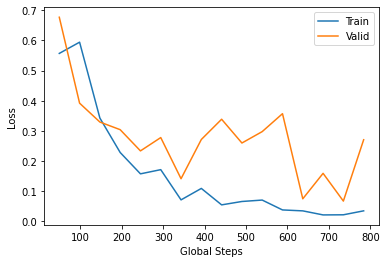

In [14]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/My Drive/TASI/ModelImbalance/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9583    0.8440    0.8976       109
           0     0.9289    0.9823    0.9548       226

    accuracy                         0.9373       335
   macro avg     0.9436    0.9132    0.9262       335
weighted avg     0.9385    0.9373    0.9362       335



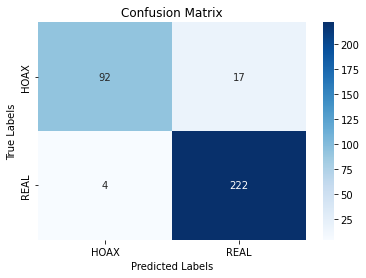

In [15]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for(labels, title, text), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['HOAX', 'REAL'])
    ax.yaxis.set_ticklabels(['HOAX', 'REAL'])

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

##Hyperparameter Tuning with Import Grid

In [16]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.3 MB/s eta 0:00:00


In [17]:
import optuna

# Define objective function to optimize hyperparameters
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 4e-5, 5e-5])
    num_epochs = trial.suggest_categorical('num_epochs', [2, 3, 4])
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32])
    
    # Define model, optimizer, and criterion
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train model
    train_loss_list, valid_loss_list, global_steps_list, best_valid_loss = train(model=model,
                                                                                  optimizer=optimizer,
                                                                                  criterion=criterion,
                                                                                  train_loader=train_iter,
                                                                                  valid_loader=valid_iter,
                                                                                  num_epochs=num_epochs,
                                                                                  eval_every=len(train_iter)//2,
                                                                                  file_path=destination_folder)

    # Save results
    key = f'lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}'
    results[key] = {
        'train_loss': train_loss_list[-1],  # save only the last train loss
        'valid_loss': valid_loss_list,
        'global_steps': global_steps_list,
        'best_valid_loss': best_valid_loss,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
    }


    # Save model if best
    if best_valid_loss < results.get('best_valid_loss', float('inf')):
        results['best_valid_loss'] = best_valid_loss
        results['best_model'] = key
        torch.save(model.state_dict(), f'{destination_folder}/model_{key}.pt')
    
    return best_valid_loss

# Set up Optuna study with GridSampler
sampler = optuna.samplers.GridSampler({'lr': [2e-5, 3e-5, 4e-5, 5e-5],
                                       'num_epochs': [2, 3, 4],
                                       'batch_size': [4, 8, 16, 32]})
study = optuna.create_study(direction='maximize', sampler=sampler)

# Run optimization
results = {}
study.optimize(objective, n_trials=48)

# Print best model and hyperparameters
best_model = results['best_model']
best_hyperparams = results[best_model]
print('Best model:', best_model)
print('Best valid loss:', best_hyperparams['best_valid_loss'])

[I 2023-03-22 13:44:50,227] A new study created in memory with name: no-name-67c9eeb1-f1ac-434c-948b-cf9a2f68a635
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5327, Valid Loss: 0.7628
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.5682, Valid Loss: 0.4549
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2900, Valid Loss: 0.1694
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [196/196], Train Loss: 0.2338, Valid Loss: 0.1884
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


[I 2023-03-22 13:45:54,557] Trial 0 finished with value: 0.16939889333610023 and parameters: {'lr': 5e-05, 'num_epochs': 2, 'batch_size': 4}. Best is trial 0 with value: 0.16939889333610023.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.4883, Valid Loss: 0.4194
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.4523, Valid Loss: 0.3165
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.2044, Valid Loss: 0.2013
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.1835, Valid Loss: 0.1924
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.0997, Valid Loss: 0.2952
Epoch [3/4], Step [294/392], Train Loss: 0.1383, Valid Loss: 0.2805
Epoch [4/4

[I 2023-03-22 13:47:53,972] Trial 1 finished with value: 0.13586455793119967 and parameters: {'lr': 4e-05, 'num_epochs': 4, 'batch_size': 16}. Best is trial 0 with value: 0.16939889333610023.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5104, Valid Loss: 0.7284
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.5056, Valid Loss: 0.3260
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2513, Valid Loss: 0.1964
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.2116, Valid Loss: 0.2336
Epoch [3/3], Step [245/294], Train Loss: 0.1190, Valid Loss: 0.2000
Epoch [3/3], Step [294/294], Train Loss: 0.1196, Valid Loss: 0.1541


[I 2023-03-22 13:49:23,938] Trial 2 finished with value: 0.1540558148242001 and parameters: {'lr': 3e-05, 'num_epochs': 3, 'batch_size': 8}. Best is trial 0 with value: 0.16939889333610023.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5322, Valid Loss: 0.7985
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.4973, Valid Loss: 0.3781
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.3380, Valid Loss: 0.3036
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.3418, Valid Loss: 0.3170
Epoch [3/4], Step [245/392], Train Loss: 0.2908, Valid Loss: 0.3861
Epoch [3/4], Step [294/392], Train Loss: 0.3172, Valid Loss: 0.3601
Epoch [4/4], Step [343/392], Train Loss: 0.2525, Valid Loss: 0.2570
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to =

[I 2023-03-22 13:51:17,545] Trial 3 finished with value: 0.2569669922813773 and parameters: {'lr': 4e-05, 'num_epochs': 4, 'batch_size': 4}. Best is trial 3 with value: 0.2569669922813773.


Epoch [4/4], Step [392/392], Train Loss: 0.2117, Valid Loss: 0.5253
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5350, Valid Loss: 0.6671
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.5017, Valid Loss: 0.3179
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2062, Valid Loss: 0.1602
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 13:52:17,426] Trial 4 finished with value: 0.16020441999925034 and parameters: {'lr': 2e-05, 'num_epochs': 2, 'batch_size': 16}. Best is trial 3 with value: 0.2569669922813773.


Epoch [2/2], Step [196/196], Train Loss: 0.1964, Valid Loss: 0.1725
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5516, Valid Loss: 0.7321
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.7091, Valid Loss: 0.7379
Epoch [2/4], Step [147/392], Train Loss: 0.5815, Valid Loss: 0.6386
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.7231, Valid Loss: 0.6417
Epoch [3/4], Step [245/392], Train Loss: 0.5170, Valid Loss: 0.7497
Epoch [3/4], Step [294/392], Train Loss: 0.4550, Valid Loss: 0.6027
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [4/4], Step [343/392], Train Loss: 0.3022, Valid Loss: 0.2364
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to =

[I 2023-03-22 13:54:11,489] Trial 5 finished with value: 0.23635012722973311 and parameters: {'lr': 4e-05, 'num_epochs': 4, 'batch_size': 32}. Best is trial 3 with value: 0.2569669922813773.


Epoch [4/4], Step [392/392], Train Loss: 0.2725, Valid Loss: 0.4427
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5226, Valid Loss: 0.5071
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.4587, Valid Loss: 0.4506
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2348, Valid Loss: 0.1768
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.2551, Valid Loss: 0.3561
Epoch [3/3], Step [245/294], Train Loss: 0.1905, Valid Loss: 0.1713
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 13:55:40,041] Trial 6 finished with value: 0.17126670277710737 and parameters: {'lr': 5e-05, 'num_epochs': 3, 'batch_size': 32}. Best is trial 3 with value: 0.2569669922813773.


Epoch [3/3], Step [294/294], Train Loss: 0.1505, Valid Loss: 0.2404
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5313, Valid Loss: 0.6671
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.5543, Valid Loss: 0.3970
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.2667, Valid Loss: 0.2193
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.2306, Valid Loss: 0.3487
Epoch [3/4], Step [245/392], Train Loss: 0.1439, Valid Loss: 0.1731
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [294/392], Train Loss: 0.1509, Valid Loss: 0.2420
Epoch [4/4

[I 2023-03-22 13:57:37,716] Trial 7 finished with value: 0.1502758649127957 and parameters: {'lr': 3e-05, 'num_epochs': 4, 'batch_size': 32}. Best is trial 3 with value: 0.2569669922813773.


Epoch [4/4], Step [392/392], Train Loss: 0.1190, Valid Loss: 0.2750
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5360, Valid Loss: 0.7363
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.6590, Valid Loss: 0.6683
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.3429, Valid Loss: 0.1704
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 13:58:37,762] Trial 8 finished with value: 0.17039384303747543 and parameters: {'lr': 3e-05, 'num_epochs': 2, 'batch_size': 4}. Best is trial 3 with value: 0.2569669922813773.


Epoch [2/2], Step [196/196], Train Loss: 0.2603, Valid Loss: 0.2933
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5356, Valid Loss: 0.7811
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.7081, Valid Loss: 0.6635
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.5660, Valid Loss: 0.6039
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.4189, Valid Loss: 0.3970
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.2260, Valid Loss: 0.1515
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model 

[I 2023-03-22 14:00:35,089] Trial 9 finished with value: 0.1514642205355423 and parameters: {'lr': 4e-05, 'num_epochs': 4, 'batch_size': 8}. Best is trial 3 with value: 0.2569669922813773.


Epoch [4/4], Step [392/392], Train Loss: 0.1581, Valid Loss: 0.2764
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5313, Valid Loss: 0.5563
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.4091, Valid Loss: 0.2557
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.2286, Valid Loss: 0.1849
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.1570, Valid Loss: 0.1381
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.0933, Valid Loss: 0.2094
Epoch [3/4], Step [294/392], Train Loss: 0.1096, Valid Loss: 0.2102
Epoch [4/4

[I 2023-03-22 14:02:28,813] Trial 10 finished with value: 0.13812003105080553 and parameters: {'lr': 2e-05, 'num_epochs': 4, 'batch_size': 16}. Best is trial 3 with value: 0.2569669922813773.


Epoch [4/4], Step [392/392], Train Loss: 0.0915, Valid Loss: 0.4003
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5101, Valid Loss: 0.6377
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.5020, Valid Loss: 0.9670
Epoch [2/2], Step [147/196], Train Loss: 0.3488, Valid Loss: 0.3431
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:03:26,323] Trial 11 finished with value: 0.34308413875156213 and parameters: {'lr': 5e-05, 'num_epochs': 2, 'batch_size': 32}. Best is trial 11 with value: 0.34308413875156213.


Epoch [2/2], Step [196/196], Train Loss: 0.3432, Valid Loss: 0.5228
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5191, Valid Loss: 0.6218
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.4795, Valid Loss: 0.8512
Epoch [2/3], Step [147/294], Train Loss: 0.3157, Valid Loss: 0.2136
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.1995, Valid Loss: 0.2681
Epoch [3/3], Step [245/294], Train Loss: 0.1219, Valid Loss: 0.2257


[I 2023-03-22 14:04:50,638] Trial 12 finished with value: 0.213622662770961 and parameters: {'lr': 3e-05, 'num_epochs': 3, 'batch_size': 4}. Best is trial 11 with value: 0.34308413875156213.


Epoch [3/3], Step [294/294], Train Loss: 0.1447, Valid Loss: 0.2686
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5392, Valid Loss: 0.6777
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.5201, Valid Loss: 0.5100
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.3020, Valid Loss: 0.3131
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.2202, Valid Loss: 0.1977
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.1287, Valid Loss: 0.2681
Epoch [3/4], Step [294/392], Train Loss: 0.1149, Valid Loss: 0.2803
Epoch [4/4

[I 2023-03-22 14:06:49,216] Trial 13 finished with value: 0.17225744051393121 and parameters: {'lr': 3e-05, 'num_epochs': 4, 'batch_size': 16}. Best is trial 11 with value: 0.34308413875156213.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.4602, Valid Loss: 0.4244
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.3484, Valid Loss: 0.3202
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2135, Valid Loss: 0.1731
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.1929, Valid Loss: 0.2930
Epoch [3/3], Step [245/294], Train Loss: 0.1620, Valid Loss: 0.1481
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:08:18,551] Trial 14 finished with value: 0.14809764801923717 and parameters: {'lr': 4e-05, 'num_epochs': 3, 'batch_size': 16}. Best is trial 11 with value: 0.34308413875156213.


Epoch [3/3], Step [294/294], Train Loss: 0.1166, Valid Loss: 0.2788
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5235, Valid Loss: 0.7975
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.6209, Valid Loss: 0.4386
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.3088, Valid Loss: 0.2409
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.2565, Valid Loss: 0.7350
Epoch [3/3], Step [245/294], Train Loss: 0.1595, Valid Loss: 0.1830
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:09:45,679] Trial 15 finished with value: 0.18299714944857573 and parameters: {'lr': 5e-05, 'num_epochs': 3, 'batch_size': 8}. Best is trial 11 with value: 0.34308413875156213.


Epoch [3/3], Step [294/294], Train Loss: 0.1457, Valid Loss: 0.2361
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5386, Valid Loss: 0.6487
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.4932, Valid Loss: 0.3995
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2354, Valid Loss: 0.1743
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [196/196], Train Loss: 0.2314, Valid Loss: 0.1498


[I 2023-03-22 14:10:49,385] Trial 16 finished with value: 0.14981290471873113 and parameters: {'lr': 3e-05, 'num_epochs': 2, 'batch_size': 16}. Best is trial 11 with value: 0.34308413875156213.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5517, Valid Loss: 0.6740
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.4643, Valid Loss: 0.2833
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.3142, Valid Loss: 0.2198
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:11:50,197] Trial 17 finished with value: 0.21982809149527124 and parameters: {'lr': 3e-05, 'num_epochs': 2, 'batch_size': 32}. Best is trial 11 with value: 0.34308413875156213.


Epoch [2/2], Step [196/196], Train Loss: 0.2762, Valid Loss: 0.4681
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5431, Valid Loss: 0.6914
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.4383, Valid Loss: 0.3959
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.1882, Valid Loss: 0.1567
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.1503, Valid Loss: 0.1464
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.1079, Valid Loss: 0.2113


[I 2023-03-22 14:13:20,752] Trial 18 finished with value: 0.14637610053510539 and parameters: {'lr': 2e-05, 'num_epochs': 3, 'batch_size': 32}. Best is trial 11 with value: 0.34308413875156213.


Epoch [3/3], Step [294/294], Train Loss: 0.1360, Valid Loss: 0.2995
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5314, Valid Loss: 0.7561
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.6572, Valid Loss: 0.4220
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2847, Valid Loss: 0.3494
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.3787, Valid Loss: 0.2642
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.2264, Valid Loss: 0.2005
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model 

[I 2023-03-22 14:14:51,562] Trial 19 finished with value: 0.16068332971605873 and parameters: {'lr': 4e-05, 'num_epochs': 3, 'batch_size': 32}. Best is trial 11 with value: 0.34308413875156213.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5319, Valid Loss: 0.7717
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.6497, Valid Loss: 0.3706
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.3337, Valid Loss: 0.3092
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.2839, Valid Loss: 0.4988
Epoch [3/4], Step [245/392], Train Loss: 0.2375, Valid Loss: 0.2753
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [294/392], Train Loss: 0.4143, Valid Loss: 0.3296
Epoch [4/4

[I 2023-03-22 14:16:45,662] Trial 20 finished with value: 0.2752831362720047 and parameters: {'lr': 5e-05, 'num_epochs': 4, 'batch_size': 8}. Best is trial 11 with value: 0.34308413875156213.


Epoch [4/4], Step [392/392], Train Loss: 0.7069, Valid Loss: 0.7111
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5319, Valid Loss: 0.8243
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.7227, Valid Loss: 0.6745
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.5942, Valid Loss: 0.8211
Epoch [2/3], Step [196/294], Train Loss: 0.7108, Valid Loss: 0.6721
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.5424, Valid Loss: 0.7686
Epoch [3/3], Step [294/294], Train Loss: 0.8108, Valid Loss: 0.6657


[I 2023-03-22 14:18:14,011] Trial 21 finished with value: 0.6656503805092403 and parameters: {'lr': 5e-05, 'num_epochs': 3, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5434, Valid Loss: 0.6664
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.4741, Valid Loss: 0.3513
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.2238, Valid Loss: 0.2979
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.2277, Valid Loss: 0.2211
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.1013, Valid Loss: 0.1869
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model 

[I 2023-03-22 14:20:12,212] Trial 22 finished with value: 0.1869068621225389 and parameters: {'lr': 3e-05, 'num_epochs': 4, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.1121, Valid Loss: 0.2246
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5584, Valid Loss: 0.7487
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.7144, Valid Loss: 0.6733
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.5459, Valid Loss: 0.6938
Epoch [2/4], Step [196/392], Train Loss: 0.6089, Valid Loss: 0.4002
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.3077, Valid Loss: 0.2203
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [294/392], Train Loss: 0.2251, Valid Loss: 0.1826
Model save

[I 2023-03-22 14:22:10,936] Trial 23 finished with value: 0.18075335128898068 and parameters: {'lr': 2e-05, 'num_epochs': 4, 'batch_size': 32}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.1416, Valid Loss: 0.2329
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5487, Valid Loss: 0.6969
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.6434, Valid Loss: 0.4607
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.3610, Valid Loss: 0.2841
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.2130, Valid Loss: 0.4198
Epoch [3/4], Step [245/392], Train Loss: 0.1935, Valid Loss: 0.1773
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [294/392], Train Loss: 0.1312, Valid Loss: 0.3678
Epoch [4/4

[I 2023-03-22 14:24:05,840] Trial 24 finished with value: 0.17729299016562955 and parameters: {'lr': 3e-05, 'num_epochs': 4, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.1113, Valid Loss: 0.3600
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5325, Valid Loss: 0.7377
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.5836, Valid Loss: 0.3269
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2649, Valid Loss: 0.2056
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.2649, Valid Loss: 0.2511
Epoch [3/3], Step [245/294], Train Loss: 0.1650, Valid Loss: 0.2274


[I 2023-03-22 14:25:33,664] Trial 25 finished with value: 0.2056115067430905 and parameters: {'lr': 5e-05, 'num_epochs': 3, 'batch_size': 16}. Best is trial 21 with value: 0.6656503805092403.


Epoch [3/3], Step [294/294], Train Loss: 0.3046, Valid Loss: 0.3404
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5381, Valid Loss: 0.6338
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.4564, Valid Loss: 0.3275
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2272, Valid Loss: 0.3142
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.1908, Valid Loss: 0.1823
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.1556, Valid Loss: 0.2185


[I 2023-03-22 14:27:01,825] Trial 26 finished with value: 0.18227879250688211 and parameters: {'lr': 2e-05, 'num_epochs': 3, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Epoch [3/3], Step [294/294], Train Loss: 0.1198, Valid Loss: 0.2831
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5297, Valid Loss: 0.7752
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.7163, Valid Loss: 0.6715
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.5636, Valid Loss: 0.7293
Epoch [2/4], Step [196/392], Train Loss: 0.4855, Valid Loss: 0.3593
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.3616, Valid Loss: 0.4510
Epoch [3/4], Step [294/392], Train Loss: 0.3330, Valid Loss: 0.2405
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [4/4

[I 2023-03-22 14:28:58,167] Trial 27 finished with value: 0.23891175352036953 and parameters: {'lr': 5e-05, 'num_epochs': 4, 'batch_size': 32}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.2551, Valid Loss: 0.4574
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5322, Valid Loss: 0.6598
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.4758, Valid Loss: 0.3621
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2464, Valid Loss: 0.2681
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.2058, Valid Loss: 0.2450
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.1570, Valid Loss: 0.1933
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model 

[I 2023-03-22 14:30:31,693] Trial 28 finished with value: 0.1932976312070553 and parameters: {'lr': 2e-05, 'num_epochs': 3, 'batch_size': 16}. Best is trial 21 with value: 0.6656503805092403.


Epoch [3/3], Step [294/294], Train Loss: 0.1375, Valid Loss: 0.3603
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5352, Valid Loss: 0.6782
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.6430, Valid Loss: 0.4517
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.2574, Valid Loss: 0.2998
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.2449, Valid Loss: 0.1843
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.1600, Valid Loss: 0.2865
Epoch [3/4], Step [294/392], Train Loss: 0.1442, Valid Loss: 0.3332
Epoch [4/4

[I 2023-03-22 14:32:29,930] Trial 29 finished with value: 0.16768894464309728 and parameters: {'lr': 2e-05, 'num_epochs': 4, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.0811, Valid Loss: 0.2478
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5288, Valid Loss: 0.7201
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.5357, Valid Loss: 0.4313
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2895, Valid Loss: 0.4942
Epoch [2/3], Step [196/294], Train Loss: 0.2498, Valid Loss: 0.2973
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.1908, Valid Loss: 0.2404
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:33:56,842] Trial 30 finished with value: 0.24043302983045578 and parameters: {'lr': 3e-05, 'num_epochs': 3, 'batch_size': 16}. Best is trial 21 with value: 0.6656503805092403.


Epoch [3/3], Step [294/294], Train Loss: 0.1285, Valid Loss: 0.3977
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5494, Valid Loss: 0.7946
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.7233, Valid Loss: 0.6876
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.4550, Valid Loss: 0.4346
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [196/196], Train Loss: 0.3549, Valid Loss: 0.2591


[I 2023-03-22 14:34:58,012] Trial 31 finished with value: 0.2590855777795826 and parameters: {'lr': 4e-05, 'num_epochs': 2, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5537, Valid Loss: 0.7117
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.6324, Valid Loss: 0.4776
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.3194, Valid Loss: 0.3465
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.2625, Valid Loss: 0.2266
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.1523, Valid Loss: 0.2678
Epoch [3/3], Step [294/294], Train Loss: 0.1523, Valid Loss: 0.1972


[I 2023-03-22 14:36:27,671] Trial 32 finished with value: 0.19724569619367166 and parameters: {'lr': 2e-05, 'num_epochs': 3, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5487, Valid Loss: 0.6931
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.5608, Valid Loss: 0.5022
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2914, Valid Loss: 0.2135
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.3104, Valid Loss: 0.1891
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.2100, Valid Loss: 0.2306


[I 2023-03-22 14:37:55,150] Trial 33 finished with value: 0.18910439951079233 and parameters: {'lr': 4e-05, 'num_epochs': 3, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Epoch [3/3], Step [294/294], Train Loss: 0.2753, Valid Loss: 0.2978
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.4914, Valid Loss: 0.4893
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.3573, Valid Loss: 0.3812
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2563, Valid Loss: 0.2387
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.2524, Valid Loss: 0.2385
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/3], Step [245/294], Train Loss: 0.1266, Valid Loss: 0.2138
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model 

[I 2023-03-22 14:39:24,795] Trial 34 finished with value: 0.2137967948219739 and parameters: {'lr': 4e-05, 'num_epochs': 3, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Epoch [3/3], Step [294/294], Train Loss: 0.1518, Valid Loss: 0.2430
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5344, Valid Loss: 0.7784
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.7131, Valid Loss: 0.6715
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.5275, Valid Loss: 0.7559
Epoch [2/4], Step [196/392], Train Loss: 0.5341, Valid Loss: 0.5447
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.2501, Valid Loss: 0.2335
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [294/392], Train Loss: 0.2625, Valid Loss: 0.3174
Epoch [4/4

[I 2023-03-22 14:41:21,311] Trial 35 finished with value: 0.1631231687829963 and parameters: {'lr': 5e-05, 'num_epochs': 4, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.1255, Valid Loss: 0.2225
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5431, Valid Loss: 0.6583
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.5761, Valid Loss: 0.3317
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2481, Valid Loss: 0.2376
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:42:23,367] Trial 36 finished with value: 0.23759005697710173 and parameters: {'lr': 2e-05, 'num_epochs': 2, 'batch_size': 32}. Best is trial 21 with value: 0.6656503805092403.


Epoch [2/2], Step [196/196], Train Loss: 0.2195, Valid Loss: 0.2558
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Step [49/294], Train Loss: 0.5340, Valid Loss: 0.6983
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/3], Step [98/294], Train Loss: 0.5165, Valid Loss: 0.4484
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [147/294], Train Loss: 0.2433, Valid Loss: 0.1768
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/3], Step [196/294], Train Loss: 0.1932, Valid Loss: 0.2311
Epoch [3/3], Step [245/294], Train Loss: 0.1871, Valid Loss: 0.2227


[I 2023-03-22 14:43:50,787] Trial 37 finished with value: 0.17681016999163798 and parameters: {'lr': 3e-05, 'num_epochs': 3, 'batch_size': 32}. Best is trial 21 with value: 0.6656503805092403.


Epoch [3/3], Step [294/294], Train Loss: 0.1202, Valid Loss: 0.2151
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5457, Valid Loss: 0.7791
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.7232, Valid Loss: 0.6707
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.4360, Valid Loss: 0.5025
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [196/196], Train Loss: 0.3170, Valid Loss: 0.3464


[I 2023-03-22 14:44:52,093] Trial 38 finished with value: 0.34644030194197384 and parameters: {'lr': 3e-05, 'num_epochs': 2, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5329, Valid Loss: 0.6999
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.5169, Valid Loss: 0.4670
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2444, Valid Loss: 0.1905
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:45:53,654] Trial 39 finished with value: 0.19045179403786147 and parameters: {'lr': 4e-05, 'num_epochs': 2, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Epoch [2/2], Step [196/196], Train Loss: 0.2208, Valid Loss: 0.3039
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5307, Valid Loss: 0.7800
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.5063, Valid Loss: 0.4187
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2497, Valid Loss: 0.2043
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:46:54,942] Trial 40 finished with value: 0.20433535596488842 and parameters: {'lr': 5e-05, 'num_epochs': 2, 'batch_size': 16}. Best is trial 21 with value: 0.6656503805092403.


Epoch [2/2], Step [196/196], Train Loss: 0.2429, Valid Loss: 0.2604
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5222, Valid Loss: 0.7433
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.4979, Valid Loss: 0.5274
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2900, Valid Loss: 0.2090
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:47:56,496] Trial 41 finished with value: 0.20895499303670867 and parameters: {'lr': 4e-05, 'num_epochs': 2, 'batch_size': 32}. Best is trial 21 with value: 0.6656503805092403.


Epoch [2/2], Step [196/196], Train Loss: 0.1921, Valid Loss: 0.3090
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5324, Valid Loss: 0.6229
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.4309, Valid Loss: 0.3365
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2468, Valid Loss: 0.1967
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:48:57,704] Trial 42 finished with value: 0.19674450870869414 and parameters: {'lr': 2e-05, 'num_epochs': 2, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Epoch [2/2], Step [196/196], Train Loss: 0.1974, Valid Loss: 0.2078
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5204, Valid Loss: 0.6332
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.5287, Valid Loss: 0.4660
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.3337, Valid Loss: 0.3081
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [196/196], Train Loss: 0.3123, Valid Loss: 0.2080


[I 2023-03-22 14:50:00,668] Trial 43 finished with value: 0.2080249022692442 and parameters: {'lr': 4e-05, 'num_epochs': 2, 'batch_size': 16}. Best is trial 21 with value: 0.6656503805092403.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5115, Valid Loss: 0.4108
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.4105, Valid Loss: 0.2710
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.2468, Valid Loss: 0.1931
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.3103, Valid Loss: 0.3764
Epoch [3/4], Step [245/392], Train Loss: 0.1871, Valid Loss: 0.1909
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [294/392], Train Loss: 0.2166, Valid Loss: 0.2371
Epoch [4/4

[I 2023-03-22 14:51:57,017] Trial 44 finished with value: 0.16065047510866343 and parameters: {'lr': 5e-05, 'num_epochs': 4, 'batch_size': 16}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.1252, Valid Loss: 0.1868
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5061, Valid Loss: 0.5284
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.4490, Valid Loss: 0.3823
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2529, Valid Loss: 0.3406
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


[I 2023-03-22 14:52:58,820] Trial 45 finished with value: 0.3406164864344256 and parameters: {'lr': 5e-05, 'num_epochs': 2, 'batch_size': 8}. Best is trial 21 with value: 0.6656503805092403.


Epoch [2/2], Step [196/196], Train Loss: 0.3279, Valid Loss: 0.3445
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/4], Step [49/392], Train Loss: 0.5255, Valid Loss: 0.6252
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/4], Step [98/392], Train Loss: 0.3921, Valid Loss: 0.2782
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [147/392], Train Loss: 0.2229, Valid Loss: 0.2746
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/4], Step [196/392], Train Loss: 0.1868, Valid Loss: 0.1570
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [3/4], Step [245/392], Train Loss: 0.1097, Valid Loss: 0.2837
Epoch [3/4], Step [294/392], Train Loss: 0.0906, Valid Loss: 0.2753
Epoch [4/4

[I 2023-03-22 14:54:55,102] Trial 46 finished with value: 0.15698214394173451 and parameters: {'lr': 2e-05, 'num_epochs': 4, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Epoch [4/4], Step [392/392], Train Loss: 0.0734, Valid Loss: 0.2764
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/2], Step [49/196], Train Loss: 0.5057, Valid Loss: 0.6485
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [1/2], Step [98/196], Train Loss: 0.4047, Valid Loss: 0.2500
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [147/196], Train Loss: 0.2093, Valid Loss: 0.1868
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Epoch [2/2], Step [196/196], Train Loss: 0.1608, Valid Loss: 0.1460


[I 2023-03-22 14:55:56,933] Trial 47 finished with value: 0.14601555593045695 and parameters: {'lr': 2e-05, 'num_epochs': 2, 'batch_size': 4}. Best is trial 21 with value: 0.6656503805092403.


Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/model.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/My Drive/TASI/ModelImbalance/metrics.pt
Finished Training!
Best model: lr=4e-05, num_epochs=4, batch_size=16
Best valid loss: 0.13586455793119967


Model loaded from <== /content/drive/My Drive/TASI/ModelImbalance/metrics.pt


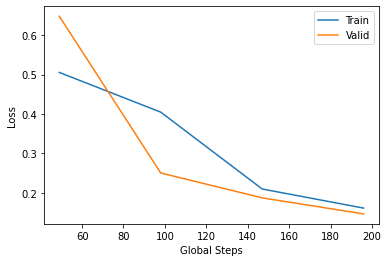

In [18]:
train_loss_list, valid_loss_list, global_steps_list, = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/My Drive/TASI/ModelImbalance/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8607    0.9633    0.9091       109
           0     0.9812    0.9248    0.9522       226

    accuracy                         0.9373       335
   macro avg     0.9209    0.9440    0.9306       335
weighted avg     0.9420    0.9373    0.9381       335



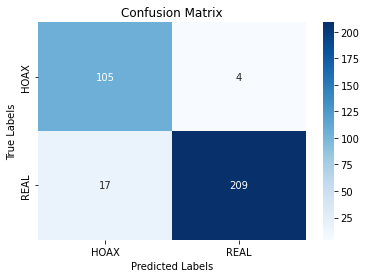

In [19]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for(labels, title, text), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['HOAX', 'REAL'])
    ax.yaxis.set_ticklabels(['HOAX', 'REAL'])

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)